In [2]:
import torch
from prepare_dataset import dataloaders, visualize_dataset
from training_logic import train_model
import bnn_as_qubo
import bnn_as_quso
from annealer import run_solver, visualize_result
from get_args import args, Solvers

usage: ipykernel_launcher.py [-h] [--batch-size N] [--test-batch-size N]
                             [--epochs N] [--lr LR] [--gamma M] [--no-cuda]
                             [--dry-run] [--seed S] [--log-interval N]
                             [--save-model]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/alipanahi/Library/Jupyter/runtime/kernel-d3031ace-af7f-4322-a2a4-6c139267c881.json


SystemExit: 2

In [221]:
# args.solver = Solvers.SIMULATED
# args.solver = Solvers.SIMULATED_EMBEDDED
args.solver = Solvers.SIMULATED
args.num_reads = 1
args.embedding_parameters = {
    'verbose': 2,  # 3 for maximum log
    'interactive': True,
    'chainlength_patience': 0,  # important to get better embedding (smaller chains)
    'max_no_improvement': 0
}

args.num_layers = 2
args.hidden_n = 2**2-1
# args.avg_pool_kernel_size = 5  # 4-> (7x7), 5 -> (9,9)
# args.avg_pool_stride = 3
args.downscale = True
# args.shape_2d = (28, 28)

args.adaptive_avg_pool_shape = 7  # 5-> (5x5), 6-> (6x6)
args.use_adaptive = True
if args.use_adaptive and args.downscale:
    args.shape_2d = (args.adaptive_avg_pool_shape, args.adaptive_avg_pool_shape)  # if not matching adaptive_avg_pool_shape/avg_pool_kernel_size won't work!

args.selected_targets = (0, 1)
# args.tau_range = [6, 7, 8, 11, 12, 13, 16, 17]  # 5x5
# args.tau_range = [1, 2, 5, 6, 9, 10, 12, 13]  # 4x4

# args.tau_range = [8, 9, 10, 14, 15, 16, 20]  # 6x6
# args.tau_range = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]  # 7x7
args.tau_range = range(1, 16)

In [222]:
vars(args)

{'batch_size': 60000,
 'test_batch_size': 1000,
 'epochs': 20,
 'lr': 1.0,
 'gamma': 0.7,
 'no_cuda': False,
 'dry_run': False,
 'seed': 1,
 'log_interval': 1000,
 'save_model': False,
 'downscale_batch_size': 100000,
 'downscale': True,
 'avg_pool_kernel_size': 6,
 'avg_pool_stride': 6,
 'adaptive_avg_pool_shape': 7,
 'shape_2d': (7, 7),
 'use_adaptive': True,
 'selected_targets': (0, 1),
 'bnn_as_quso': False,
 'bnn_as_qubo_dimod': False,
 'solver': <Solvers.SIMULATED: 2>,
 'num_reads': 1,
 'num_anneals': 1000,
 'gurobi_threads': 16,
 'visualize_dataset': True,
 'visualize_result_': True,
 'use_binary_net2': False,
 'dataset_spin_form': True,
 'optimizer': 'adadelta',
 'use_scheduler': False,
 'remove_contradicting': True,
 'sample_output': False,
 'shuffle': False,
 'solution_as_tensors': True,
 'LAMBDA': {'hard_constraints': 1, 'tau': 1, 'epsilon': 1},
 'epsilon': 6,
 'num_classes': 2,
 'num_layers': 2,
 'hidden_n': 3,
 'flatten_dataset': True,
 'pad_flattened_dataset': True,
 'emb

Removing contradicting images from Training set
Initial number of images:  12665
Number of unique images: 3246
Number of unique num_1s:  367
Number of unique num_2s:  2868
Number of unique contradicting labels (both num_1 and num_2):  11
Remaining non-contradicting unique images:  3235

Removing contradicting images from Test set
Initial number of images:  2115
Number of unique images: 864
Number of unique num_1s:  132
Number of unique num_2s:  732
Number of unique contradicting labels (both num_1 and num_2):  0
Remaining non-contradicting unique images:  864

Training set shape: [63]


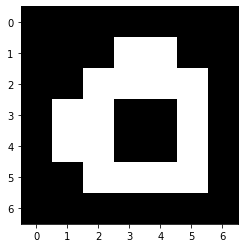

In [223]:
train_dataloader, test_dataloader = dataloaders(args)

In [224]:
model = train_model(train_dataloader, test_dataloader, args)
model

Total Number of parameters of Model: 192
Test set: Average loss: 18.7500, Accuracy: 702/864 (81.25%)
Test set: Average loss: 17.1296, Accuracy: 716/864 (82.87%)
Test set: Average loss: 15.5093, Accuracy: 730/864 (84.49%)
Test set: Average loss: 13.8889, Accuracy: 744/864 (86.11%)
Test set: Average loss: 8.7963, Accuracy: 788/864 (91.20%)
Test set: Average loss: 8.7963, Accuracy: 788/864 (91.20%)
Test set: Average loss: 7.5231, Accuracy: 799/864 (92.48%)
Test set: Average loss: 8.6806, Accuracy: 789/864 (91.32%)
Test set: Average loss: 7.2917, Accuracy: 801/864 (92.71%)
Test set: Average loss: 7.9861, Accuracy: 795/864 (92.01%)
Test set: Average loss: 6.4815, Accuracy: 808/864 (93.52%)
Test set: Average loss: 6.5972, Accuracy: 807/864 (93.40%)
Test set: Average loss: 3.1250, Accuracy: 837/864 (96.88%)
Test set: Average loss: 3.1250, Accuracy: 837/864 (96.88%)
Test set: Average loss: 3.3565, Accuracy: 835/864 (96.64%)
Test set: Average loss: 3.1250, Accuracy: 837/864 (96.88%)
Test set: A

BinaryNet(
  (fc_list): ModuleList(
    (0): BinaryLinear(in_features=63, out_features=3, bias=False)
    (1): BinaryLinear(in_features=3, out_features=1, bias=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

In [225]:
# if args.sample_output:
samples = next(iter(train_dataloader))
print('Batch size:', len(samples[0]))
sample_pred = model(samples[0])
sample_target = samples[1]
print(sample_pred)
print(sample_target)
print('Accuracy', (1-(sample_pred - sample_target).sum()/len(sample_pred))*100)

Batch size: 3235
tensor([0., 1., 1.,  ..., 0., 0., 0.], grad_fn=<SqueezeBackward0>)
tensor([0., 1., 1.,  ..., 0., 0., 0.])
Accuracy tensor(98.7635, grad_fn=<MulBackward0>)


In [226]:
for image_index in range(len(train_dataloader)):
    sample_input_item = train_dataloader.dataset[image_index]
    sample_input_spin = sample_input_item[0]
    sample_input_target = sample_input_item[1]
    shape = sample_input_spin.shape[-2:]
    # if the model already predict the sample with an incorrect class, let's skip.
    if model(sample_input_spin) != sample_input_target:
        continue
    break

In [227]:
H_dimod = None
H, qubo_vars = bnn_as_qubo.setup_optim_model(sample_input_spin, sample_input_target,
                                      model, args)

In [228]:
from neal import SimulatedAnnealingSampler
import matplotlib.pyplot as plt
from binarized_neural_net import *
import dwave.inspector
from get_args import Solvers
from utils import to_spin, to_boolean
from minorminer import find_embedding
from dwave.system.composites import EmbeddingComposite, FixedEmbeddingComposite
import torch
from bnn_as_qubo_grb import set_up_grb_model_qubo
from dimod import BinaryQuadraticModel, Vartype
from dwave.system import DWaveSampler
import networkx as nx
import dimod
from hybrid.reference.kerberos import KerberosSampler


In [229]:

def print_degrees(dwave_qubo):
    G = nx.Graph()
    G.add_weighted_edges_from([(u[0], u[1], v) for u, v in dwave_qubo.items()])
    degree_dict = dict(G.degree(G.nodes()))
    degrees = sorted(degree_dict.values(), reverse=True)
    print('Top 20 Max Degrees')
    print(degrees[:20])
    return degrees

def exec_solver(H, args, H_dimod=None):
    qubo_emb = None
    print('# chain_strength:', args.chain_strength)
    solver = args.solver
    # Get the QUBO form of the H
    qv_qubo = H.to_qubo()

    # D-Wave accept QUBOs in a different format than qubovert's format
    # to get the qubo in this form, use the .Q property
    dwave_qubo = qv_qubo.Q
    # print(dwave_qubo)
    print('#####################')
    print('Epsilon')
    print(args.epsilon)
    bqm = BinaryQuadraticModel(Vartype.BINARY).from_qubo(dwave_qubo, H.offset)
    print('No. of Variables')
    print(len(H.variables))
    print('No. of Quadratic Terms')
    print(qv_qubo.num_terms - qv_qubo.num_binary_variables)
    print_degrees(dwave_qubo)
    print('Solver')
    print(solver)
    if solver == Solvers.SIMULATED:
        if H_dimod:
            bqm = H_dimod
        sim_sampler = SimulatedAnnealingSampler()
        res = sim_sampler.sample_qubo(bqm.to_qubo()[0], num_reads=args.num_reads)
        print('Image shape')
        print(args.shape_2d)
        print('No. of Neural Networks layer')
        print(args.num_layers)
        print('Tau range')
        print(args.tau_range)
        print('solution energy')
        print(res.first.energy)
#         print('QUBO')
#         print(dwave_qubo)
#         print('Solution')
#         print(res.first.sample)
        qubo_solution = res.first.sample
        if H_dimod:
            H_solution = qubo_solution
        else:
            H_solution = H.convert_solution(qubo_solution)
        print("Constraints satisfied?")
        print(H.is_solution_valid(H_solution))
        print('#####################')
    elif solver == Solvers.SIMULATED_EMBEDDED:
        # bqm.normalize(1, 4)
        d_sampler = DWaveSampler()
        _, edgelist, adjacency = d_sampler.structure
        print('>>> find embedding')
        embedding = find_embedding(dwave_qubo, edgelist, random_seed=1, **args.embedding_parameters)
        bqm_emb = dwave.embedding.embed_bqm(bqm, embedding, adjacency, chain_strength=args.chain_strength)
        # bqm_emb.normalize(1, 4)
        print('# embedded variables', bqm_emb.num_variables)
        qubo_emb = bqm_emb.to_qubo()[0]
        print('# emb quad term:', bqm_emb.num_interactions)
        print_degrees(qubo_emb)
        sim_sampler = SimulatedAnnealingSampler()
        # res = sim_sampler.sample_qubo(qubo_emb, num_reads=args.num_reads)
        res = sim_sampler.sample(bqm_emb, num_reads=args.num_reads)
        res = dwave.embedding.unembed_sampleset(res, embedding, bqm)
        qubo_solution = res.first.sample
        # embedding_rev = {v_: k for k, v in embedding.items() for v_ in v}
        # qubo_solution = {embedding_rev[k]: v for k, v in qubo_solution.items()}
        H_solution = H.convert_solution(qubo_solution)
    elif solver == Solvers.DWAVE:
        sampler = DWaveSampler()
        _, edgelist, adjacency = sampler.structure
        print('>>> find embedding')
        # dwave_qubo_bqm.normalize(1, 4)
        dwave_qubo_bqm_qubo = bqm.to_qubo()
        embedding = find_embedding(dwave_qubo_bqm_qubo[0], edgelist, random_seed=1, **args.embedding_parameters)
        sampler = FixedEmbeddingComposite(sampler, embedding)
        res = sampler.sample_qubo(dwave_qubo_bqm_qubo[0], num_reads=args.num_reads, annealing_time=50)
        dwave.inspector.show(res)
        qubo_solution = res.first.sample

        # convert the qubo solution back to the solution to the H
        H_solution = H.convert_solution(qubo_solution)
    else:
        raise NotImplemented()

    # print("Variable assignment:", H_solution)
    if not H_dimod:
        print("H value:", H.value(H_solution))
    return H_solution, res, qubo_emb

H_solution, res, qubo_emb = exec_solver(H, args, H_dimod)

# chain_strength: None
#####################
Epsilon
6
No. of Variables
85
No. of Quadratic Terms
838
Top 20 Max Degrees
[23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
Solver
Solvers.SIMULATED
Image shape
(7, 7)
No. of Neural Networks layer
2
Tau range
range(1, 16)
solution energy
-1873.0
Constraints satisfied?
False
#####################
H value: 2.0


In [230]:
import numpy as np
invalidValues, validValues = [], []
for sample in res:
    H_solution = H.convert_solution(sample)
    values = invalidValues
    if H.is_solution_valid(H_solution):
        values = validValues
    values.append(H.value(H_solution))
validValues

[]

In [231]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

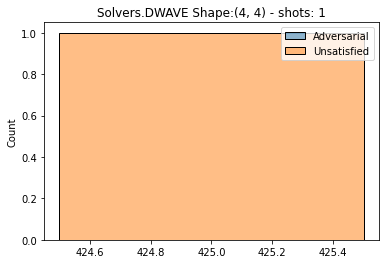

In [216]:
sns.histplot({'Adversarial': validValues, 'Unsatisfied': invalidValues}, color=['r','b'], alpha=0.5) \
  .set(title=f'{args.solver} Shape:{args.shape_2d} - shots: {args.num_reads}');

In [217]:
# visualize_result(model, sample_input_spin, sample_input_target, H_solution, shape, args)

In [218]:
import networkx as nx

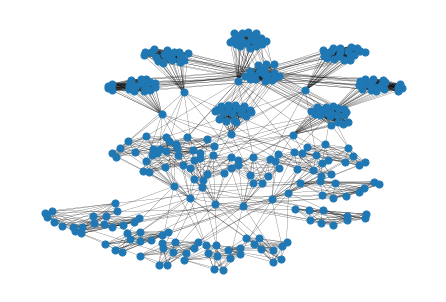

In [219]:
edges = [k for k in H.to_qubo().Q.keys() if k[0] != k[1]]
G = nx.Graph()
G.add_edges_from(edges)
nx.draw(G, with_labels=False, node_size= 50, width=0.2)

In [220]:
edges = [k for k in qubo_emb.keys() if k[0] != k[1]]
G = nx.Graph()
G.add_edges_from(edges)
nx.draw(G, with_labels=False, node_size= 50, width=0.2, pos=nx.spring_layout(G, iterations=1000))

AttributeError: 'NoneType' object has no attribute 'keys'